In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [43]:
distance_vector = [0.5197, 0.4404, 0.4850, 0.4222, 0.4132, 0.4371, 0.3912, 0.3949, 
                   1.3910, 0.4276, 0.4075, 0.3956, 2.4053, 0.4752, 0.5032, 0.5273, 
                   0.4879]
theta_vector = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

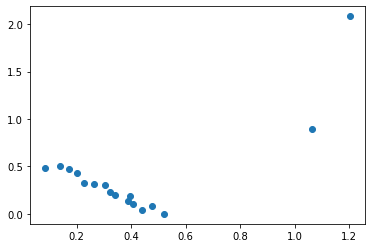

In [44]:
x_arr = [d * math.cos(theta * math.pi / 180) for (d, theta) in zip(distance_vector, theta_vector)]
y_arr = [d * math.sin(theta * math.pi / 180) for (d, theta) in zip(distance_vector, theta_vector)]

plt.scatter(x_arr, y_arr)

### removing outlier data 

In [45]:
# since outlier data ruins results of pseudo inverse, we are removing it.
x_arr = np.delete(x_arr, 8)
x_arr = np.delete(x_arr, 11)
y_arr = np.delete(y_arr, 8)
y_arr = np.delete(y_arr, 11)

In [46]:
x_arr = np.array(x_arr)
y_arr = np.array(y_arr)
dots = np.vstack((x_arr, y_arr)).T
dots

array([[0.5197    , 0.        ],
       [0.43872415, 0.03838339],
       [0.47763176, 0.08421937],
       [0.40781388, 0.1092734 ],
       [0.38828099, 0.14132272],
       [0.39614713, 0.18472644],
       [0.33878914, 0.1956    ],
       [0.32348314, 0.22650533],
       [0.30235886, 0.30235886],
       [0.26193595, 0.31216311],
       [0.22690684, 0.32405655],
       [0.2008282 , 0.43067746],
       [0.17210454, 0.47285333],
       [0.13647528, 0.50933269],
       [0.08472295, 0.4804877 ]])

### 1. Pseudo inverse 

In [47]:
def pseudo_inverse(x: np.array) -> np.array: 
    """
    Fits a line to the set of specified array(dots) and returns list of gradient and intercept.
    
    """
    
    CONST = np.ones(shape=(x.shape[0], 1))
    
    x_transpose = x.transpose()
    symmetric_matrix = np.dot(x_transpose, x)
    print(symmetric_matrix)
    inv_matrix = np.linalg.inv(symmetric_matrix)
    
    temp = np.dot(inv_matrix, x_transpose)
    pair = np.dot(temp, CONST)
    return pair[:, 0]

In [31]:
a, b = pseudo_inverse(dots)
a, b

[[1.69139878 0.89402867]
 [0.89402867 1.35740776]]


(1.9638145597760945, 1.5148387249632296)

In [32]:
pseudo_inverse_m = -a / b
pseudo_inverse_c = 1 / b

In [33]:
def draw_plot(x, y, m, c, title=None):
    """
    plots a line with slope=m and y-intercept=c
    """
    y2 = m * x + c
    if title is not None:
        plt.title(title)
    plt.scatter(x, y)
    plt.plot(x, y2, 'r', label='y3')
    #plt.plot(x_arr, y)
    plt.grid()
    plt.show()

### with/without outliers

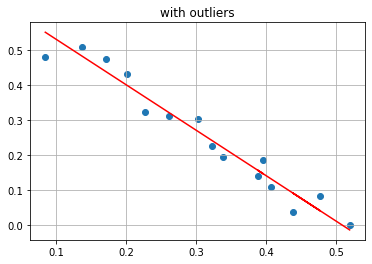

In [34]:
draw_plot(x_arr, y_arr, pseudo_inverse_m, pseudo_inverse_c, title='with outliers')

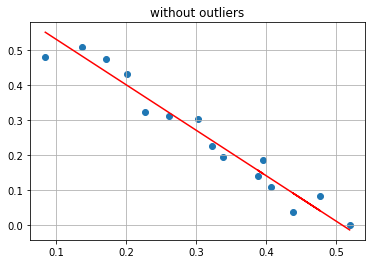

In [35]:
draw_plot(x_arr, y_arr, pseudo_inverse_m, pseudo_inverse_c, title='without outliers')

### 2. RANSAC

In [36]:
def fit_line(point0, point1):
    """
    Fits a line through two given points.
    
    :return: returns slope and y-intercept of line.
    """
    
    m = (point1[1] - point0[1]) / (point1[0] - point0[0])
    c = -m * point0[0] + point0[1]
    
    return m, c

In [37]:
def find_intercept_point(m, c, x0, y0):
    """
    finds an intercept point in line with slope=m and y-intercept=c from another line 
    with point=(x0, y0) that is orthogonal to it.
    
    :return: returns slope and y-intercept(m2, c2) of intercept point.
    """
    
    x1 = (x0 + m * y0 - m * c) / (m ** 2 + 1)
    y1 = ((m ** 2) * y0 + m * x0 + c) / (m ** 2 + 1)
    
    return x1, y1

In [38]:
def euclidean_distance(x0, y0, x1, y1):
    """
    returns direct distance between two given points.
    """
    y = mx + c
    -mx + y -c = 0
    ax + by +c = =
    d = math.sqrt((y1 - y0) ** 2 + (x1 - x0) ** 2)
    return d

In [39]:
def ransac_approach(points: np.array):
    """
    Plots set of inliers in each step and returns best probably slope and y-intercept of all possible lines
    :return: returns (m, c) of best line.
    """
    
    SAMPLE_NUM = 2
    NUM_OF_ITERATIONS = points.shape[0] - SAMPLE_NUM
    TH_DISTANCE = 0.3
    
    best_m = 0
    best_c = 0
    max_inliers_len = 0
    for i in range(NUM_OF_ITERATIONS):
        # Select two points randomly
        indices = np.random.choice(points.shape[0], SAMPLE_NUM, replace=False)
        random_points = points[indices]

        other_points = []
        for j in range(points.shape[0]):
            if j not in indices:
                other_points.append(points[j])

        size = points.shape[0] - SAMPLE_NUM
        other_points = np.array(other_points).reshape(size, 2)

        m, c = fit_line(random_points[0], random_points[1])
        
        inlier_set = []
        inlier_length = 0
        for test_point in other_points:
            x0 = test_point[0]
            y0 = test_point[1]
            
            x1, y1 = find_intercept_point(m, c, x0, y0)
            
            dist = euclidean_distance(x0, y0, x1, y1)
            
            if dist < TH_DISTANCE:
                inlier_set.append([x0, y0])
                inlier_length += 1
        
        inlier_set = np.array(inlier_set).reshape(inlier_length, 2)
        
        if inlier_length > max_inliers_len:
            max_inliers_len = inlier_length
            best_m = m
            best_c = c
            
        title = 'iteration {}'.format(i)
        draw_plot(points[:, 0], points[:, 1], best_m, best_c, title=title)
    
    
    draw_plot(points[:, 0], points[:, 1], best_m, best_c, title="Ransac Final Approach(probabilistic)")
    return best_m, best_c
        

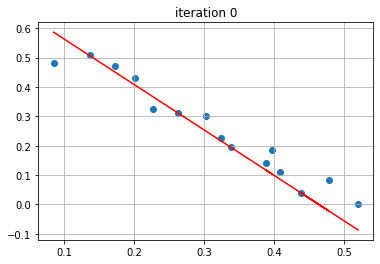

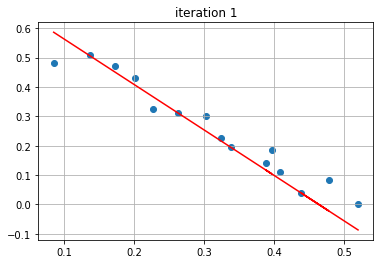

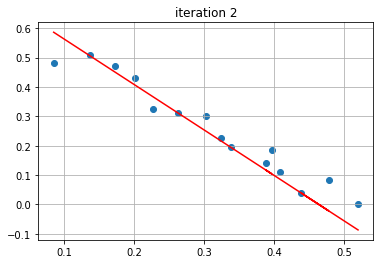

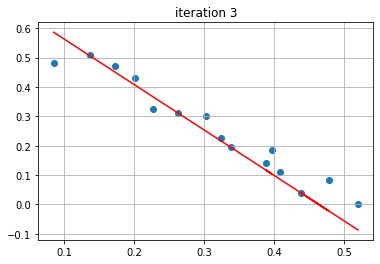

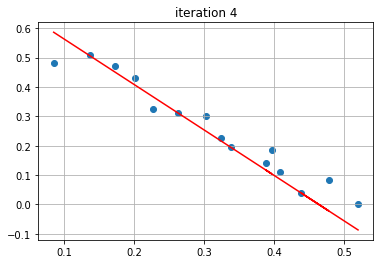

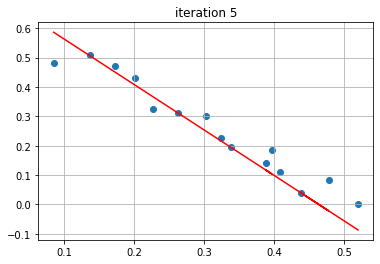

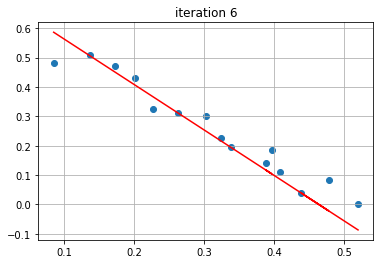

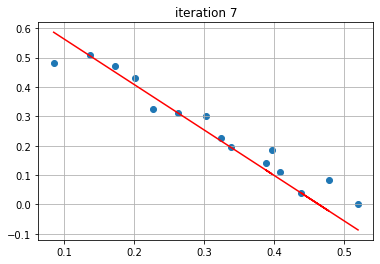

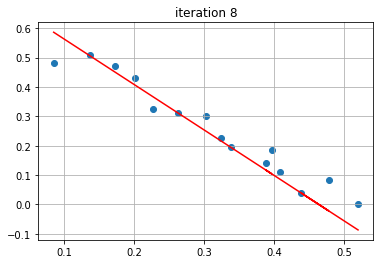

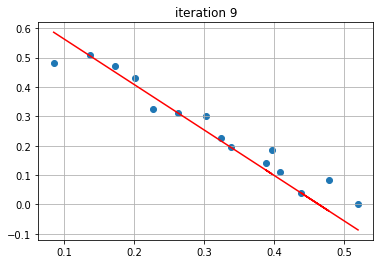

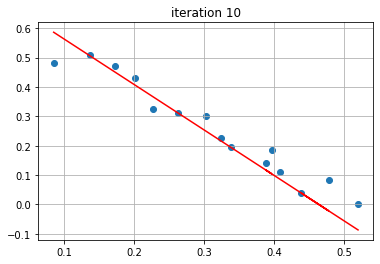

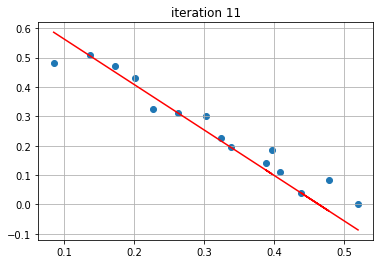

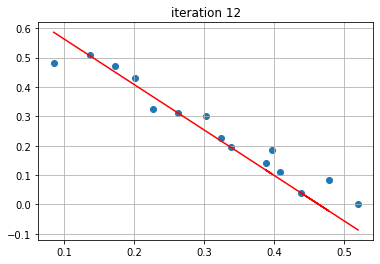

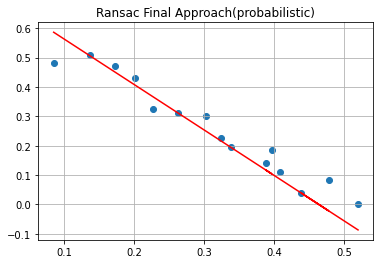

In [40]:
ransac_m, ransac_c = ransac_approach(dots)

### Compare both approaches

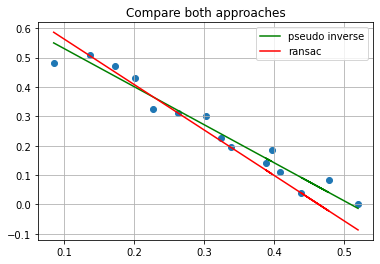

In [41]:
y_1 = pseudo_inverse_m * x_arr + pseudo_inverse_c
y_2 = ransac_m * x_arr + ransac_c

plt.title("Compare both approaches")
plt.scatter(x_arr, y_arr)
plt.plot(x_arr, y_1, '-g', label='pseudo inverse')
plt.plot(x_arr, y_2, '-r', label='ransac')
plt.legend()
plt.grid()
plt.show()